<a href="https://colab.research.google.com/github/ShepherdCode/ShepherdML/blob/master/Nasa2021/GRU_103.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRU 101
LSTM 403 modified to use Bi-directional GRU layers 

In [1]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
MODEL_FILE='LSTM302'   # load not save!
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=100
SPLITS=1
K=3
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
NEURONS=16
DROP=0.4
ACT="tanh"

Mounted at /content/drive/


In [2]:
# Load our own tools
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [4]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    embed_layer  = keras.layers.Embedding(
        #VOCABULARY_SIZE, EMBED_DIMEN, input_length=1000, input_length=1000, mask_zero=True)
        #input_dim=[None,VOCABULARY_SIZE], output_dim=EMBED_DIMEN, mask_zero=True)
        input_dim=VOCABULARY_SIZE, output_dim=EMBED_DIMEN, mask_zero=True)
    rnn1_layer = keras.layers.Bidirectional(keras.layers.GRU(NEURONS, return_sequences=True, 
          input_shape=[1000,EMBED_DIMEN], activation=ACT, dropout=DROP))
    rnn2_layer = keras.layers.Bidirectional(keras.layers.GRU(NEURONS, return_sequences=False, 
        activation=ACT, dropout=DROP)) #Bi
    dense1_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop1_layer = keras.layers.Dropout(DROP)
    dense2_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop2_layer = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)
    mlp = keras.models.Sequential()
    mlp.add(embed_layer)
    mlp.add(rnn1_layer)
    mlp.add(rnn2_layer)
    mlp.add(dense1_layer)
    mlp.add(drop1_layer)
    mlp.add(dense2_layer)
    mlp.add(drop2_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

Partition sequences

In [5]:
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

Cross validation

In [6]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [7]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=tools.make_kmers(K,MAXLEN,subset)
#print ("Data prep")
#X_train=tools.make_frequencies(K,X_train)

Load data from files.
Ready: train_set
Data reshape


In [8]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          1040      
_________________________________________________________________
bidirectional (Bidirectional (None, None, 32)          3264      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                4800      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_____________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.model/assets


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 83s 143ms/step - loss: 0.6434 - accuracy: 0.6421 - val_loss: 0.5642 - val_accuracy: 0.7256


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 2/100
453/453 [==============================] - 61s 135ms/step - loss: 0.5849 - accuracy: 0.7099 - val_loss: 0.5412 - val_accuracy: 0.7393


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 3/100
453/453 [==============================] - 61s 135ms/step - loss: 0.5725 - accuracy: 0.7147 - val_loss: 0.5321 - val_accuracy: 0.7405


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 4/100
453/453 [==============================] - 62s 136ms/step - loss: 0.5559 - accuracy: 0.7252 - val_loss: 0.5036 - val_accuracy: 0.7635


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 5/100
453/453 [==============================] - 62s 136ms/step - loss: 0.5285 - accuracy: 0.7411 - val_loss: 0.6131 - val_accuracy: 0.6816
Epoch 6/100
453/453 [==============================] - 62s 136ms/step - loss: 0.5317 - accuracy: 0.7369 - val_loss: 0.3973 - val_accuracy: 0.8262


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 7/100
453/453 [==============================] - 62s 137ms/step - loss: 0.4479 - accuracy: 0.7952 - val_loss: 0.4314 - val_accuracy: 0.7896
Epoch 8/100
453/453 [==============================] - 64s 142ms/step - loss: 0.4253 - accuracy: 0.8120 - val_loss: 0.3740 - val_accuracy: 0.8299


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 9/100
453/453 [==============================] - 62s 137ms/step - loss: 0.4206 - accuracy: 0.8171 - val_loss: 0.3728 - val_accuracy: 0.8287
Epoch 10/100
453/453 [==============================] - 62s 137ms/step - loss: 0.4171 - accuracy: 0.8097 - val_loss: 0.4307 - val_accuracy: 0.8070
Epoch 11/100
453/453 [==============================] - 62s 137ms/step - loss: 0.4089 - accuracy: 0.8236 - val_loss: 0.3640 - val_accuracy: 0.8324


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 12/100
453/453 [==============================] - 62s 137ms/step - loss: 0.4097 - accuracy: 0.8220 - val_loss: 0.3719 - val_accuracy: 0.8231
Epoch 13/100
453/453 [==============================] - 62s 138ms/step - loss: 0.4028 - accuracy: 0.8267 - val_loss: 0.3636 - val_accuracy: 0.8336


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 14/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3984 - accuracy: 0.8268 - val_loss: 0.3554 - val_accuracy: 0.8448


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 15/100
453/453 [==============================] - 62s 137ms/step - loss: 0.4041 - accuracy: 0.8245 - val_loss: 0.3554 - val_accuracy: 0.8411
Epoch 16/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3991 - accuracy: 0.8324 - val_loss: 0.3548 - val_accuracy: 0.8423
Epoch 17/100
453/453 [==============================] - 63s 139ms/step - loss: 0.4036 - accuracy: 0.8246 - val_loss: 0.3468 - val_accuracy: 0.8448
Epoch 18/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3945 - accuracy: 0.8292 - val_loss: 0.3489 - val_accuracy: 0.8430
Epoch 19/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3929 - accuracy: 0.8279 - val_loss: 0.3618 - val_accuracy: 0.8361
Epoch 20/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3892 - accuracy: 0.8348 - val_loss: 0.3400 - val_accuracy: 0.8436
Epoch 21/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3906 - accuracy: 0.8323 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 22/100
453/453 [==============================] - 65s 144ms/step - loss: 0.3818 - accuracy: 0.8366 - val_loss: 0.3499 - val_accuracy: 0.8479


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 23/100
453/453 [==============================] - 64s 142ms/step - loss: 0.3699 - accuracy: 0.8455 - val_loss: 0.3608 - val_accuracy: 0.8492


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 24/100
453/453 [==============================] - 65s 143ms/step - loss: 0.3783 - accuracy: 0.8423 - val_loss: 0.3289 - val_accuracy: 0.8541


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 25/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3698 - accuracy: 0.8452 - val_loss: 0.3434 - val_accuracy: 0.8510
Epoch 26/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3726 - accuracy: 0.8398 - val_loss: 0.3272 - val_accuracy: 0.8560


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 27/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3589 - accuracy: 0.8511 - val_loss: 0.3279 - val_accuracy: 0.8473
Epoch 28/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3676 - accuracy: 0.8477 - val_loss: 0.3334 - val_accuracy: 0.8572


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 29/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3638 - accuracy: 0.8460 - val_loss: 0.3210 - val_accuracy: 0.8641


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 30/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3571 - accuracy: 0.8482 - val_loss: 0.3509 - val_accuracy: 0.8448
Epoch 31/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3686 - accuracy: 0.8406 - val_loss: 0.3180 - val_accuracy: 0.8678


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 32/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3598 - accuracy: 0.8509 - val_loss: 0.3116 - val_accuracy: 0.8721


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 33/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3519 - accuracy: 0.8552 - val_loss: 0.3211 - val_accuracy: 0.8641
Epoch 34/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3526 - accuracy: 0.8524 - val_loss: 0.3256 - val_accuracy: 0.8616
Epoch 35/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3640 - accuracy: 0.8517 - val_loss: 0.3106 - val_accuracy: 0.8703
Epoch 36/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3444 - accuracy: 0.8611 - val_loss: 0.3379 - val_accuracy: 0.8603
Epoch 37/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3473 - accuracy: 0.8578 - val_loss: 0.3026 - val_accuracy: 0.8740


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 38/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3542 - accuracy: 0.8524 - val_loss: 0.3045 - val_accuracy: 0.8759


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 39/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3419 - accuracy: 0.8621 - val_loss: 0.3195 - val_accuracy: 0.8709
Epoch 40/100
453/453 [==============================] - 63s 140ms/step - loss: 0.3458 - accuracy: 0.8580 - val_loss: 0.2938 - val_accuracy: 0.8802


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 41/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3433 - accuracy: 0.8574 - val_loss: 0.3425 - val_accuracy: 0.8597
Epoch 42/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3402 - accuracy: 0.8598 - val_loss: 0.3053 - val_accuracy: 0.8696
Epoch 43/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3385 - accuracy: 0.8608 - val_loss: 0.3040 - val_accuracy: 0.8727
Epoch 44/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3387 - accuracy: 0.8591 - val_loss: 0.3010 - val_accuracy: 0.8678
Epoch 45/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3300 - accuracy: 0.8682 - val_loss: 0.2896 - val_accuracy: 0.8790
Epoch 46/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3407 - accuracy: 0.8589 - val_loss: 0.3068 - val_accuracy: 0.8634
Epoch 47/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3237 - accuracy: 0.8685 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 50/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3354 - accuracy: 0.8631 - val_loss: 0.2865 - val_accuracy: 0.8858


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 51/100
453/453 [==============================] - 63s 140ms/step - loss: 0.3224 - accuracy: 0.8663 - val_loss: 0.3015 - val_accuracy: 0.8703
Epoch 52/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3301 - accuracy: 0.8683 - val_loss: 0.2888 - val_accuracy: 0.8821
Epoch 53/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3206 - accuracy: 0.8677 - val_loss: 0.2856 - val_accuracy: 0.8827
Epoch 54/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3286 - accuracy: 0.8678 - val_loss: 0.2927 - val_accuracy: 0.8765
Epoch 55/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3173 - accuracy: 0.8712 - val_loss: 0.2883 - val_accuracy: 0.8845
Epoch 56/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3214 - accuracy: 0.8705 - val_loss: 0.2861 - val_accuracy: 0.8845
Epoch 57/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3250 - accuracy: 0.8723 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 63/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3025 - accuracy: 0.8784 - val_loss: 0.2832 - val_accuracy: 0.8783
Epoch 64/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3132 - accuracy: 0.8737 - val_loss: 0.2856 - val_accuracy: 0.8833
Epoch 65/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3128 - accuracy: 0.8758 - val_loss: 0.2763 - val_accuracy: 0.8876


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 66/100
453/453 [==============================] - 64s 142ms/step - loss: 0.3110 - accuracy: 0.8753 - val_loss: 0.2967 - val_accuracy: 0.8783
Epoch 67/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3116 - accuracy: 0.8732 - val_loss: 0.2889 - val_accuracy: 0.8845
Epoch 68/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3102 - accuracy: 0.8746 - val_loss: 0.2833 - val_accuracy: 0.8845
Epoch 69/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3104 - accuracy: 0.8758 - val_loss: 0.2843 - val_accuracy: 0.8802
Epoch 70/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3025 - accuracy: 0.8782 - val_loss: 0.2904 - val_accuracy: 0.8821
Epoch 71/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3116 - accuracy: 0.8755 - val_loss: 0.3169 - val_accuracy: 0.8684
Epoch 72/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3080 - accuracy: 0.8779 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 78/100
453/453 [==============================] - 62s 137ms/step - loss: 0.2892 - accuracy: 0.8859 - val_loss: 0.2781 - val_accuracy: 0.8876
Epoch 79/100
453/453 [==============================] - 62s 137ms/step - loss: 0.2959 - accuracy: 0.8818 - val_loss: 0.2887 - val_accuracy: 0.8796
Epoch 80/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3020 - accuracy: 0.8801 - val_loss: 0.2827 - val_accuracy: 0.8821
Epoch 81/100
453/453 [==============================] - 62s 136ms/step - loss: 0.3006 - accuracy: 0.8809 - val_loss: 0.2745 - val_accuracy: 0.8845
Epoch 82/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3034 - accuracy: 0.8784 - val_loss: 0.2800 - val_accuracy: 0.8802
Epoch 83/100
453/453 [==============================] - 62s 138ms/step - loss: 0.2936 - accuracy: 0.8808 - val_loss: 0.2941 - val_accuracy: 0.8721
Epoch 84/100
453/453 [==============================] - 63s 138ms/step - loss: 0.2879 - accuracy: 0.8880 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 100/100
453/453 [==============================] - 62s 137ms/step - loss: 0.2852 - accuracy: 0.8869 - val_loss: 0.2861 - val_accuracy: 0.8790
Fold 1, 100 epochs, 7368 sec


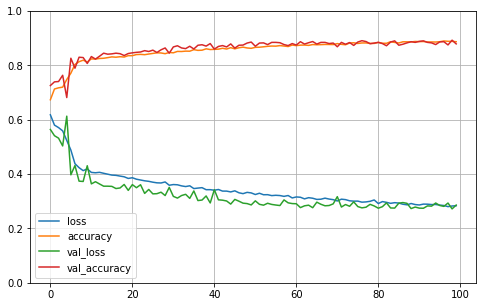

accuracy: 89.26%

1-way Cross Validation mean 89.26% (+/- 0.00%)
Done


In [9]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")